<a href="https://colab.research.google.com/github/Tecnologico-de-Monterrey-MNA/nlp-2023_Equipo-6/blob/main/Equipo_06_Semana_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Objetivo de la Actividad**


> Trabajar con estos modelos pre-entrenados, generando el vocabulario a partir de tu conjunto de datos de entrenamiento.

Para cada palabra de tu vocabulario, podrás sustituirlo por su correspondiente
vector continuo. En caso de que no exista el vector para una palabra en particular, se puede eliminar dicha palabra, o bien sustituirla por el vector continuo más cercano.

En esta actividad deberás aplicar esta segunda opción.

-----

*   Existen diversas propuestas para utilizar dichos vectores continuos como entrada para modelos de aprendizaje automático. En particular, en esta actividad cada enunciado será sustituido por el vector promedio de todos los tokens que lo forman.

**Modelos:**

Modelo de vectores **continuos/embebidos FastText**, es decir, el modelo desarrollado por Facebook en 2016.

##**Pregunta 1**

Descarga los **3 archivos de Canvas**. En particular, el archivo de datos de **IMDb** ya no requiere transformarse **para obtener sus 1000 registros**. Al cargar los datos de los tres archivos deberás tener un **DataFrame de Pandas de 3000 registros**, con sus etiquetas. Los archivos los encuentras en Canvas y se llaman: **amazon5.txt, imdb5.txt, yelp5.txt.**

In [1]:
import pandas as pd
import numpy as np

import re
import string

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer, WordNetLemmatizer, RegexpStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz

--2024-05-18 12:36:16--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.155.173.40, 18.155.173.116, 18.155.173.80, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.155.173.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz.1’

cc.en.300.vec.gz.1  100%[===================>]   1.23G  52.8MB/s    in 22s     

2024-05-18 12:36:38 (57.5 MB/s) - ‘cc.en.300.vec.gz.1’ saved [1325960915/1325960915]

gzip: cc.en.300.vec already exists; do you wish to overwrite (y or n)? ^C


#**Aplicando NLTK**

In [3]:
nltk.download('punkt')        # Tokenizador que ayuda a dividr el texto en enunciados
nltk.download('stopwords')    # Acceso a "stopwords" en varios idiomas.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Lista de stopwords que se incluyen de manera predeterminada la suite de librerías de NLTK

print(len(stopwords.words('english')))
print(stopwords.words('english'))

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [5]:
#Se extraen los archivos desde repositorio público de GitHub
url1 = 'https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/amazon5.txt'
url2 = 'https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/imdb5.txt'
url3 = 'https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/yelp5.txt'

#Se cargan los archivos en dataframe de Pandas
dfa5 = pd.read_csv(url1, sep='\t', names=['review','label'], header=None, encoding='utf-8')
dfi5 = pd.read_csv(url2, sep=' {3,4}', names=['review','label'], header=None, encoding='utf-8')
dfy5 = pd.read_csv(url3, sep='\t', names=['review','label'], header=None, encoding='utf-8')

#Se imprime la forma de los dataframes
print('Total de registros de Amazon_5:',dfa5.shape)
print('Total de registros de IMBD_5:',dfi5.shape)
print('Total de registros de Yelp_5:',dfy5.shape)

<ipython-input-5-dd740832e87d>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dfi5 = pd.read_csv(url2, sep=' {3,4}', names=['review','label'], header=None, encoding='utf-8')


Total de registros de Amazon_5: (1000, 2)
Total de registros de IMBD_5: (1000, 2)
Total de registros de Yelp_5: (1000, 2)


In [6]:
dfi5.head()

,review,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [7]:
#Concatenar los 3,000 registros

df = pd.concat([dfa5, dfi5, dfy5], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


Al realizar la revisión del conjunto de datos se observa que el dataset de **imdb5** tiene 1.000 flotantes. Lo que requiere una limpieza especial para dicho dataset. --- **Sin embargo, se encontró que al cargar con el separador correcto, el siguiente paso no es necesario**.

In [ ]:
#dfi5.info()

In [ ]:
#no necesario
#print(dfi5_c.isnull().sum())

In [ ]:
#no necesario con la limpieza anterior
#print(df['label'].isnull().sum())

In [ ]:
#no necesario con la limpieza anterior
#dfii5_l = dfi5.fillna(0)
#dfii5_l.head()

In [ ]:
#No necesario con la limpieza anterior
#df = pd.concat([dfa5, dfii5_l, dfy5], ignore_index=True)
#df.info()

In [8]:
X = df.review     # Serie de strings
Y = df.label      # Serie de enteros 0s y 1s

assert X.shape == (3000,)           # verificando que tenemos la dimensiones esperadas.
assert Y.shape == (3000,)

#**Pregunta 2**

Realiza de nuevo un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado, sin embargo, deberás aplicar necesariamente alguna de las técnicas de lematización. Como aplicaremos modelos embebidos pre-entrenados, queremos palabras lo más cercanas a las existentes en un idioma, inglés en este caso. Aplica y justifica cualquier otro proceso de limpieza que consideres
adecuado. Recuerda que en esta actividad se usarán vectores embebidos para un problema de clasificación, por lo que deberás tomar de acuerdo a este contexto. Justifica todas las transformaciones que se apliquen.



**Procedimiento para quitar las negaciones del conjunto de stopwords en caso de ser necesario**

In [9]:
# Consideremos la siguiente lista de palabras asociada a negaciones en inglés:

mystopwords = stopwords.words('english')

negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

#Se asigna las stopwords de NLTK a mystopwords
mystopwords_without_neg = stopwords.words('english')

#Se revisa si cada una de las palabras en negwords está presente en mystopwords
for word in negwords:
  if word in mystopwords_without_neg:
    mystopwords_without_neg.remove(word)           # si la palabra está presente, quitarla de la lista

#Se imprime la longitud y elementos de negwords para verificar resultados
print(len(negwords))
print(negwords)

#Se imprime la longitud y elementos de los stop words de NLTK para verificar resultados
print(len(mystopwords))
print(mystopwords)

print(len(mystopwords_without_neg))
print(mystopwords_without_neg)

40
['no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about'

**NOTA**: Es importante tener en cuenta, que en el análisis de sentimientos debemos abarcar el vocabulario suficiente que nos permita entender la opinión del usuario y así mismo identificar aquellas opiniones que puden enriquecer y construir una interacción más amena con el cliente. Para ello, Se considera realizar una depuración de las negaciones que no agregan valor al resultado del diccionario que se requiere y que no definen a profundidad el sentimiento del cliente, estas se pueden ser reemplazadas por un vector continuo más cercano.

In [10]:
def clean_tok(doc):
  ##############################################################################
  # AGREGA AQUÍ TUS LÍNEAS DE CÓDIGO - Pregunta 4:

  # Eliminación de signos de puntuación, caracteres especiales.

  doc = doc.lower()    #normalización a minúsculas

  #Sólo caracteres alfabéticos
  puntuacion = re.sub(r'[^a-z]', ' ', doc)                  #considerar solo caracteres alfabéticos
  puntuacion = re.sub(r'\d{2, }', ' ', puntuacion.strip())  #eliminar todo tipo de espacios que se encuentren

# Tokenizar
  tokenizar = puntuacion.split()                            #tomar el resultado anterior y aplicar método de tokenización a partir del método split

# Eliminación de Stopwords

  tokens = []

  for i in tokenizar:
    if i not in mystopwords:                                #en esta ocasión para elimianr los stopwords se toma la librería de corpus el mismo método.
      tokens.append(i)

  for nwtokens in tokens:
    if len(nwtokens)<=1:
      tokens.remove(nwtokens)

  # FIN PARA AGREGAR TUS LÍNEAS DE CÓDIGO.
  ##############################################################################

  return tokens

In [11]:
Xcleantok = [clean_tok(x) for x in X]

In [12]:
df.head()

,review,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [13]:
for x in Xcleantok[0:5]:
  print(x)

['way', 'plug', 'us', 'unless', 'go', 'converter']
['good', 'case', 'excellent', 'value']
['great', 'jawbone']
['tied', 'charger', 'conversations', 'lasting', 'minutes', 'major', 'problems']
['mic', 'great']


#**Método Limpieza por Lematizazión**

In [14]:
#lista vacía para análisis visual
palabras = []

#ciclo para juntar todos los tokens previos en una lista
for tokens1 in Xcleantok:

  palabras.extend(tokens1)

#Set para eliminar repeticiones
dic = set(palabras)

#Imprimir resultados para análisis visual
print(sorted(dic))


#Se crea un objeto de la clase PorterStemmer
#ps = PorterStemmer() #Se requiere usar lematización para utilizar el método de vectores embebidos

#Se crea un objeto de la clase WordNetLemmatizer
WNL = WordNetLemmatizer()

#Definición de la función de limpieza adicional
def clean_doc(doc):

  #Se define lista vacía para los nuevos tokens
  # tokens = stemmer_tokens(doc)
  tokens = []

  #Ciclo para la limpieza de los tokens
  for j in range(0,len(doc)):

    #Encontar todas las variantes de so, good, fox, way y frequently
    so = re.findall(r"so{2,}\b", doc[j])
    good = re.findall(r"go{2,}d{1,}\b", doc[j])
    fox = re.findall(r"fo{1,}x{1,}\b", doc[j])
    way = re.findall(r"wa{1,}y{1,}\b", doc[j])
    frequently = re.findall(r"frequent*[a-z]+ly\b", doc[j])

    #Si se encontraron variantes de 'so', reemplazarlas
    if len(so) > 0:

      doc[j] = 'so'

    #Si se encontraron variantes de 'good', reemplazarlas
    if len(good) > 0:

      doc[j] = 'good'

    #Si se encontraron variantes de 'fox', reemplazarlas
    if len(fox) > 0:

      doc[j] = 'fox'

    #Si se encontraron variantes de 'way', reemplazarlas
    if len(way) > 0:

      doc[j] = 'way'

    #Si se encontraron variantes de 'frequently', reemplazarlas
    if len(frequently) > 0:

      doc[j] = 'frequently'

    #Se aplica stemming lo cual nos llevará las palabras a su base, incluyendo remover las terminaciones 'ing','ed','s'
    #doc[j] = ps.stem(doc[j]) #Se aplica lematización en lugar de stemming

    lem_token = doc[j]

    #Sólo lematizar tokens mas de más de dos caracteres

    if len(lem_token) > 2:

      #Se intenta lematizar verbo
      lem_token = WNL.lemmatize(doc[j],'v')

      #Si el token permanece sin cambios, intentar lematizar como sustantivo
      if lem_token == doc[j]:
        lem_token = WNL.lemmatize(doc[j],'n')

      #Si el token permanece sin cambios, intentar lematizar como adjetivo
      elif lem_token == doc[j]:
        lem_token = WNL.lemmatize(doc[j],'a')

      #Si el token permanece sin cambios, intentar lematizar como advervio
      elif lem_token == doc[j]:
        lem_token = WNL.lemmatize(doc[j],'r')

    #Asignar el resultado a doc[j]
    doc[j] = lem_token

  tokens.extend(doc)

  return tokens

['aailiyah', 'abandoned', 'abhor', 'ability', 'able', 'abound', 'abroad', 'absolute', 'absolutel', 'absolutely', 'absolutley', 'abstruse', 'abysmal', 'ac', 'academy', 'accents', 'accept', 'acceptable', 'access', 'accessable', 'accessible', 'accessing', 'accessory', 'accessoryone', 'accident', 'accidentally', 'acclaimed', 'accolades', 'accommodations', 'accomodate', 'accompanied', 'according', 'accordingly', 'accountant', 'accurate', 'accurately', 'accused', 'ache', 'achievement', 'achille', 'ackerman', 'acknowledged', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'activate', 'activated', 'activesync', 'actor', 'actors', 'actress', 'actresses', 'actual', 'actually', 'ad', 'adams', 'adaptation', 'adapter', 'adapters', 'add', 'added', 'addition', 'additional', 'address', 'adhesive', 'admins', 'admiration', 'admitted', 'adorable', 'adrift', 'adventure', 'advertised', 'advise', 'aerial', 'aesthetically', 'affected', 'affleck', 'affordable', 'afraid', 'africa', 'afternoon', 'age',

In [15]:
# Aplicamos el proceso de limpieza/normalización adicionales:

Xclean = [clean_doc(x) for x in Xcleantok]

In [16]:
Xclean[0:20]

[['way', 'plug', 'us', 'unless', 'go', 'converter'],
 ['good', 'case', 'excellent', 'value'],
 ['great', 'jawbone'],
 ['tie', 'charger', 'conversation', 'last', 'minute', 'major', 'problem'],
 ['mic', 'great'],
 ['jiggle', 'plug', 'get', 'line', 'right', 'get', 'decent', 'volume'],
 ['several',
  'dozen',
  'several',
  'hundred',
  'contact',
  'imagine',
  'fun',
  'send',
  'one',
  'one'],
 ['razr', 'owner', 'must'],
 ['needle', 'say', 'waste', 'money'],
 ['waste', 'money', 'time'],
 ['sound', 'quality', 'great'],
 ['impress', 'go', 'original', 'battery', 'extend', 'battery'],
 ['two',
  'seperated',
  'mere',
  'ft',
  'start',
  'notice',
  'excessive',
  'static',
  'garble',
  'sound',
  'headset'],
 ['good', 'quality', 'though'],
 ['design', 'odd', 'ear', 'clip', 'comfortable'],
 ['highly', 'recommend', 'one', 'blue', 'tooth', 'phone'],
 ['advise', 'everyone', 'fool'],
 ['far', 'good'],
 ['work', 'great'],
 ['click',
  'place',
  'way',
  'make',
  'wonder',
  'long',
  'mecha

#**Pregunta 3**

Llamar Xclean a los comentarios procesados y Y a las etiquetas. Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente. Verifica que obtienes 2,100 registros de entrenamiento y 450 para cada uno de validación y prueba.


In [17]:
# Xclean = Comentarios procesados
# Y = etiquetas

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, Y, train_size=.70, shuffle=True, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)

print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


# **Pregunta 4**

- Usando el conjunto de entrenamiento genera un vocabulario que no sea mayor a 1,500 palabras, ni menor a 1,000.

>> **¿Por qué es importante acotar un vocabulario inferior y superiormente? ¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el diccionario?**

>>*Se acota el vocabulario porque se emplean las palabras que sólo aportan valor al análisis del corpus, generalmente las que tienen mayor frecuencia de aparición. Se emplea únicamente el diccionario del conjunto de entrenamiento para evitar el filtrado de información cuando se verifica el desempeño del modelo en los conjuntos de validación y prueba. Solamente estarán disponibles los elementos del diccionario del conjunto de entrenamiento para realizar las predicciones en los conjuntos posteriores.*

- Con este vocabulario que obtienes, filtra los conjuntos de entrenamiento, validación y prueba, de esta manera todos los comentarios usarán solamente palabras válidas de acuerdo a este vocabulario.

- Indica el tamaño del vocabulario obtenido.

- Hasta este punto básicamente has realizado transformaciones muy análogas a las de la semana pasada y que son válidas para muchos de los procesos dentro del análisis de textos.

- En dado caso comenta con tus compañeros de equipo qué diferencias has observado. Veamos ahora la diferencia con respecto a las matrices Tf-idf que aplicaste la semana pasada, con respecto a los vectores **preentrenados embebidos.**

Longitud del diccionario: 3265

(word,frequency):
[('good', 165), ('movie', 140), ('great', 138), ('phone', 134), ('film', 130), ('work', 113), ('like', 101), ('time', 101), ('one', 100), ('go', 89)]


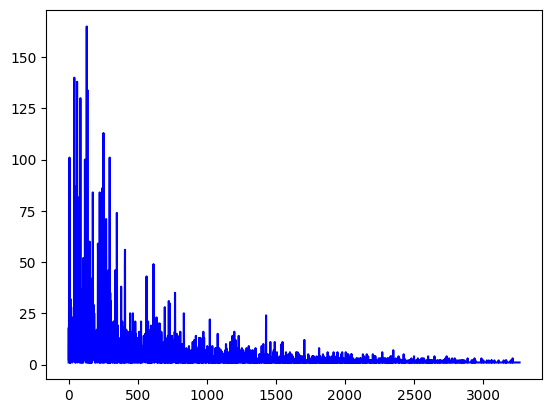

In [18]:
#Se importa el módulo Counter
from collections import Counter

#Se importa el módulo plt
import matplotlib.pyplot as plt

#Se asigna un objeto de clase Counter
midiccionario = Counter()

#Se crea el diccionario con las palabras del conjunto de entrenamiento
for k in range(len(x_train)):
  midiccionario.update(x_train[k])


print('Longitud del diccionario:', len(midiccionario))
print('\n(word,frequency):')
print(midiccionario.most_common(10))

# Veamos la gráfica de palabras nuestro diccionario con base a la frecuencia de las palabras/tokens:
plt.plot(list(np.arange(len(midiccionario))), list(midiccionario.values()), color='blue')
plt.show()

**Filtrado por frecuencia de aparición hasta llegar al tamaño de vocabulario deseado**

In [19]:
#Frecuencia mínima deseada
min_freq = 2

#Copia de midiccionario para realizar operaciones
midicc = midiccionario.copy()

#Ciclo para filtar los elementos con base a su frecuencia
for x in midiccionario:
  if midiccionario[x] < min_freq:
    del midicc[x]   #Eliminar tokens con menos frecuencia que la deseada

print('Nueva longitud del nuevo vocabulario:', len(midicc))
print(list(midicc.items())[0:5])     # veamos algunos elementos del diccionario.

Nueva longitud del nuevo vocabulario: 1429
[('star', 18), ('fare', 2), ('much', 39), ('better', 38), ('people', 23)]


In [20]:
#Se filtran los todos los conjuntos con el nuevo diccionario
train_x = []
train_y = []
for ss, y in zip(x_train, y_train):
  tokens = []
  for w in ss:
    if w in midicc:
      tokens.append(w)

  #Solo añadir a las listas si el token existe en el diccionario
  if len(tokens) > 0:
    train_x.append(tokens)
    train_y.append(y)

val_x = []
val_y = []
for ss, y in zip(x_val, y_val):
  tokens = []
  #train_x.append([w for w in ss if w in midicc])
  for w in ss:
    if w in midicc:
      tokens.append(w)

  #Solo añadir a las listas si el token existe en el diccionario
  if len(tokens) > 0:
    val_x.append(tokens)
    val_y.append(y)

test_x = []
test_y = []
for ss, y in zip(x_test, y_test):
  tokens = []
  #train_x.append([w for w in ss if w in midicc])
  for w in ss:
    if w in midicc:
      tokens.append(w)

  #Solo añadir a las listas si el token existe en el diccionario
  if len(tokens) > 0:
    test_x.append(tokens)
    test_y.append(y)

In [21]:
# Podemos ver algunos de los comentarios de entrenamiento, antes y después
# de incluir la condición de la frecuencia mínima de ocurrencia de un token:

for k in range(3):
  print('Antes:', x_train[k])
  print('Antes x_train:', len(x_train))
  print('Antes y_train:', len(y_train))
  print('Después:', train_x[k])
  print('Después:', len(train_x))
  print('Después:', len(train_y))

Antes: ['co', 'star', 'fare', 'much', 'better', 'people', 'like', 'morgan', 'freeman', 'jonah', 'hill', 'ed', 'helm', 'waste']
Antes x_train: 2100
Antes y_train: 2100
Después: ['star', 'fare', 'much', 'better', 'people', 'like', 'morgan', 'ed', 'waste']
Después: 2090
Después: 2090
Antes: ['tonight', 'elk', 'filet', 'special', 'suck']
Antes x_train: 2100
Antes y_train: 2100
Después: ['tonight', 'filet', 'special', 'suck']
Después: 2090
Después: 2090
Antes: ['pay', 'bill', 'tip', 'felt', 'server', 'terrible', 'job']
Antes x_train: 2100
Antes y_train: 2100
Después: ['pay', 'bill', 'tip', 'felt', 'server', 'terrible', 'job']
Después: 2090
Después: 2090


# **Pregunta 5**
Utilizarás los vectores embebidos FastText preentrenados por Facebook.

Incluye una tabla comparativa de pros y contras entre los modelos FastText, word2vec de Google y Glove de Stanford. Puedes consultar sus páginas correspondientes:
- https://fasttext.cc/
- https://code.google.com/archive/p/word2vec/
- https://nlp.stanford.edu/projects/glove/

| Características | FastText | Word2Vec | GloVe |
| ----------- | ----------- | ----------- | ----------- |
| **Institución desarrolladora** | Facebook AI | Google | Stanford University |
| **Modelo** | Basado en la arquitectura de skip-gram y CBOW | Basado en las arquitecturas de skip-gram y CBOW | Basado en la matriz de co-ocurrencia de palabras en el corpus |
| **Manejo de palabras fuera del vocabulario (OOV)** | Buen manejo gracias al uso de n-grams subwords | No lo soporta | No lo soporta |
| **Manejo de palabras raras** | Buen manejo gracias al uso de n-grams subwords | Puede tener dificultades con palabras raras | Buen manejo dependiendo de la frecuencia en la matriz de co-ocurrencia |
| **Velocidad de entrenamiento** | Media | Rápido | Lento en comparación con FastText y Word2Vec debido al uso de la matriz de co-ocurrencia |
| **Dimensiones de los vectores** | Configurable, hasta 300 dimensiones | Configurable, hasta 300 dimensiones | Configurable, hasta 300 dimensiones |
| **Requisitos de memoria** | Moderados, debido a los subwords n-grams | Bajos, sólo necesita palabras y contextos | Altos, debido a la matriz de co-ocurrencia |
| **Interpretación semántica** | Buena, similar a Word2Vec | Buena, basada en contextos cercanos | Buena, basada en relaciones semánticas y sintácticas |


<br>

Es importante mencionar que cada uno de estos modelos puede ser el más adecuado dependiendo de las necesidades específicas del problema que se esté abordando.

Por ejemplo, si necesitas manejar palabras fuera del vocabulario o palabras raras, FastText podría ser la mejor opción; si la memoria es una limitación, Word2Vec podría ser más adecuado; GloVe, por otro lado, podría ser más útil para capturar relaciones semánticas y sintácticas entre palabras.

Por otro lado, GloVe podría desempeñarse mejor que Word2Vec para tareas de analogía de palabras, y también muestra un desempeño superior en tareas de similitud y de reconocimiento de nombre de entidades. Mientras que FastText logra un mejor desempeño en tareas sintácticas. Por último, Word2Vec sobrepasa a FastText en tareas semánticas.


# **Pregunta 6**
Utiliza el modelo **FastText** de vectores embebidos pre-entrenados de dimensión 300 para generar un nuevo diccionario clave-valor, donde la “clave” será cada token o palabra de tu vocabulario y el “valor” será su vector embebido de dimensión 300. Este diccionario deberá ser del mismo tamaño que el vocabulario previo que hayas construido previamente.
https://fasttext.cc/docs/en/crawl-vectors.html

**NOTA**: Debido a la cantidad de recursos computacionales que demanda cargar los vectores FastText (son 2 millones de vectores), es recomendable que una vez que generes el nuevo vocabulario de vectores embebidos, guardes dicho diccionario en un archivo (pickle, npz o el que consideres más adecuado). Una vez realizado lo anterior, puedes borrar la variable de FastText para liberar memoria RAM. De esta manera, ya tienes tu vocabulario de vectores embebidos de acuerdo a los tokens que consideras más adecuados para tu problema y puedes usarlo rápidamente
cuando lo necesites. En dado caso apóyense entre los miembros del equipo de tener dificultades para generar el vocabulario y por mientras puedes usar el archivo del vocabulario que alguno haya generado.

**Se instala el módulo de Cython y FastText**

In [22]:
!pip install fasttext
!pip install Cython --install-option="--no-cython-compile"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227136 sha256=088394a3a7875f24b96121e8d171087822e05eceaa5e44d7afeea48763720479
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --install-option


**Se importa el módulo de fasttext**

In [23]:
import fasttext
import fasttext.util

#Se descargan los el modelo de idioma inglés
fasttext.util.download_model('en', if_exists='ignore')  # English

'cc.en.300.bin'

In [25]:
#Se utiliza el modelo FastText de vectores embebidos pre-entrenados de dimensión 300
ft = fasttext.load_model('cc.en.300.bin')

In [26]:
#Copia de midicc para realizar operaciones
midicc_vec = midicc.copy()

#asignar el vector resultante a cada elemento del diccionario
for x in midicc_vec:
  midicc_vec[x] = ft.get_word_vector(x)

print('Longitud del vocabulario de vectores embebidos:', len(midicc_vec))
print('Las dimensiones de midicc_vec son: {},{}'.format(len(midicc_vec), len(list(midicc_vec.items())[0][1])))   # veamos algunos elementos del diccionario.
print(list(midicc_vec.items())[0:1])     # veamos algunos elementos del diccionario.

Longitud del vocabulario de vectores embebidos: 1429
Las dimensiones de midicc_vec son: 1429,300
[('star', array([-2.86828041e-01,  1.15123533e-01,  5.38213179e-02,  6.26803637e-02,
        2.47128960e-02, -2.57342309e-02,  1.47269234e-01, -1.16852485e-01,
        1.43789779e-02,  2.02018499e-01, -6.00243136e-02, -6.75183982e-02,
       -4.77372715e-03,  4.89413664e-02,  1.16688116e-02, -3.23957461e-03,
       -1.23359617e-02, -8.51226449e-02, -4.92033921e-02,  6.35383427e-02,
        8.86741839e-03,  1.40952796e-01,  1.09847665e-01,  1.25429276e-02,
       -4.25020084e-02, -8.08417723e-02,  2.70867231e-03,  3.24510969e-02,
        1.41084492e-02,  1.06206566e-01,  1.08138800e-01, -5.41383438e-02,
        5.69636673e-02,  5.37327491e-02, -7.06092343e-02, -9.78406295e-02,
       -1.20484188e-01, -4.16465327e-02, -8.21356028e-02,  4.71536033e-02,
        9.90687776e-03,  4.89758067e-02, -1.33870468e-01, -1.54928997e-01,
       -1.81018680e-01,  1.78726465e-02,  7.79893203e-03, -8.5920289

# **Pregunta 7**
Una manera de utilizar los vectores embebidos con modelos de aprendizaje automático en
documentos de texto, es asignar a cada comentario filtrado el vector embebido de dimensión 300
que resulta de promediar todos sus tokens. Así, en este ejercicio deberás generar los arreglos
correspondientes para los conjuntos de entrenamiento, validación y prueba. Los llamaremos
trainEmb, valEmb y testEmb, respectivamente.

In [27]:
#Funcion para calcular el promedio de vectores en un documento
def promedio_de_lista_de_vectores(vec_docs):

  #Lista vacía
  #vectores_promedio = []

  #Ciclo para extraer el documento de vectores
  for i in range(0,len(vec_docs)):

    if i == 0:

      #Se calcula el promedio de todos los vectores
      vectores_promedio = [np.mean(vec_docs[i], axis = 0)]

    else:
      vector_promedio = [np.mean(vec_docs[i], axis = 0)]

      #Se añade a la lista de vectores promedio
      vectores_promedio = np.append(vectores_promedio, vector_promedio, axis = 0)

  return vectores_promedio

In [28]:
#función para transformar un conjunto de documentos a sus vectores embebidos en un diccionario
def documento_a_documento_de_vectores_embebidos(docs, vect_dic):

#Se inicializan lista vacía para el promedio de los vectores
  emb_vect_doc = []

  #Ciclo para extraer cada documento del conjunto
  for doc in docs:

    #Lista vacía temporal para juntar los vectores del diccionario
    tmp_doc = []

    #Ciclo para extraer todos los tokens del documento
    for token in doc:

      #Se obtiene y añade a la lista el vector correspondiente
      tmp_doc.append(vect_dic[token])

    #Se añade a la lista de vectores
    emb_vect_doc.append(tmp_doc)

  return emb_vect_doc

In [29]:
#Se transforman todos los tokens de cada documento a su vector correspondiente en el diccionario
train_x_vect = documento_a_documento_de_vectores_embebidos(train_x, midicc_vec)
val_x_vect = documento_a_documento_de_vectores_embebidos(val_x, midicc_vec)
test_x_vect = documento_a_documento_de_vectores_embebidos(test_x, midicc_vec)

print('La cantidad de elementos train_x_vect es: {}\n'.format(len(train_x_vect)))
print('La cantidad de elementos val_x_vect es: {}\n'.format(len(val_x_vect)))
print('La cantidad de elementos test_x_vect es: {}\n'.format(len(test_x_vect)))

La cantidad de elementos train_x_vect es: 2090

La cantidad de elementos val_x_vect es: 443

La cantidad de elementos test_x_vect es: 443



**¿Cuáles son sus dimensiones?**

In [30]:
#Se calculan los vectores promedio de cada conjunto de documentos
trainEmb = promedio_de_lista_de_vectores(train_x_vect)
valEmb = promedio_de_lista_de_vectores(val_x_vect)
testEmb = promedio_de_lista_de_vectores(test_x_vect)

print('Las dimensiones de trainEmb son: {}\n'.format(trainEmb.shape))
print('Las dimensiones de valEmb son: {}\n'.format(valEmb.shape))
print('Las dimensiones de testEmb son: {}\n'.format(testEmb.shape))

Las dimensiones de trainEmb son: (2090, 300)

Las dimensiones de valEmb son: (443, 300)

Las dimensiones de testEmb son: (443, 300)



**¿Se podrían usar para su representación matrices dispersas (sparse matrices) como en el caso de la matriz Tf-idf?**

Si, se podrían usar matrices dispersas (sparse matrices) para representar los vectores embebidos en documentos de texto, al igual que en el caso de la matriz Tf-idf. Pero este no operaría de manera eficiente, sus resultados serían más generalizados.

Para nuestro caso, al obtener el promedio de todos los vectores presentes en cada documento, se obtuvieron vectores de 300 elementos cada uno con valores distintos a cero. En este caso se tiene una matriz densa, no una dispersa como las que se tratan en Ti-idf.


# **Pregunta 8**
Utiliza los modelos de regresión lineal y bosque aleatorio (random forest) y encuentra sus
desempeños (accuracy). Compara los resultados con los de la semana anterior.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

Definición del modelo y rango inicial de hiperparámetros:



In [32]:
from sklearn.ensemble import RandomForestClassifier

# Definir rango inicial de hiperparámetros
max_depth_range = [5, 10, 15, 20, None]
min_samples_leaf_range = [1, 2, 4, 8]
min_samples_split_range = [2, 5, 10, 20]

# Crear modelo inicial
rf_model = RandomForestClassifier()

Evaluación manual de diferentes combinaciones de hiperparámetros:



In [33]:
from sklearn.model_selection import cross_val_score

best_score = 0
best_params = {}

for max_depth in max_depth_range:
    for min_samples_leaf in min_samples_leaf_range:
        for min_samples_split in min_samples_split_range:
            rf_model = RandomForestClassifier(max_depth=max_depth,
                                              min_samples_leaf=min_samples_leaf,
                                              min_samples_split=min_samples_split)

            scores = cross_val_score(rf_model, trainEmb, train_y, cv=5)
            mean_score = scores.mean()

            if mean_score > best_score:
                best_score = mean_score
                best_params = {
                    'max_depth': max_depth,
                    'min_samples_leaf': min_samples_leaf,
                    'min_samples_split': min_samples_split
                }

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor puntaje de validación cruzada: {best_score:.3f}")

Mejores hiperparámetros: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mejor puntaje de validación cruzada: 0.774


Ajuste final con GridSearchCV o RandomizedSearchCV en un rango acotado:



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Rango acotado de hiperparámetros basado en resultados previos
param_dist = {
    'max_depth': [best_params['max_depth'] - 2, best_params['max_depth'], best_params['max_depth'] + 2, None],
    'min_samples_leaf': [best_params['min_samples_leaf'] - 1, best_params['min_samples_leaf'], best_params['min_samples_leaf'] + 1],
    'min_samples_split': [best_params['min_samples_split'] - 2, best_params['min_samples_split'], best_params['min_samples_split'] + 2]
}

rf_random = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1)
rf_random.fit(trainEmb, train_y)

print(f"Mejores hiperparámetros: {rf_random.best_params_}")
print(f"Mejor puntaje de validación cruzada: {rf_random.best_score_:.3f}")

Evaluación en el conjunto de prueba:



In [ ]:
final_model = rf_random.best_estimator_
test_accuracy = final_model.score(testEmb, test_y)
print(f"Exactitud en el conjunto de prueba: {test_accuracy:.3f}")

Definición del Modelo y Rango Inicial de Hiperparámetros


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Definir rango inicial de hiperparámetros
C_range = [0.01, 0.1, 1, 10, 100]
penalty_options = ['l1', 'l2', 'elasticnet', 'none']

# Crear modelo inicial
lr_model = LogisticRegression(solver='saga', max_iter=5000)


Evaluación Manual de Diferentes Combinaciones de Hiperparámetros


In [ ]:
best_score = 0
best_params = {}

for C in C_range:
    for penalty in penalty_options:
        try:
            lr_model = LogisticRegression(C=C, penalty=penalty, solver='saga', max_iter=5000)
            scores = cross_val_score(lr_model, trainEmb, train_y, cv=5)
            mean_score = scores.mean()
            if mean_score > best_score:
                best_score = mean_score
                best_params = {
                    'C': C,
                    'penalty': penalty
                }
        except ValueError:
            # Algunos penaltys pueden no ser compatibles con todos los solvers
            continue

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor puntaje de validación cruzada: {best_score:.3f}")


Ajuste Final con GridSearchCV o RandomizedSearchCV


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Rango acotado de hiperparámetros basado en resultados previos
param_dist = {
    'C': [best_params['C'] / 2, best_params['C'], best_params['C'] * 2],
    'penalty': [best_params['penalty']],
    'solver': ['saga'],  # Usamos saga para elasticnet y l1
    'l1_ratio': [0.5] if best_params['penalty'] == 'elasticnet' else [None]  # Solo necesario para elasticnet
}

# Crear y ajustar el modelo con RandomizedSearchCV
lr_random = RandomizedSearchCV(lr_model, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1)
lr_random.fit(trainEmb, train_y)

print(f"Mejores hiperparámetros: {lr_random.best_params_}")
print(f"Mejor puntaje de validación cruzada: {lr_random.best_score_:.3f}")


Evaluación en el Conjunto de Prueba


In [ ]:
final_model = lr_random.best_estimator_
test_accuracy = final_model.score(testEmb, test_y)
print(f"Exactitud en el conjunto de prueba: {test_accuracy:.3f}")


*Se obtienen resultados similares a los obtenidos en la semana anterior. El modelo de regresión logística logra exactitudes por encima del 72% y el modelo de Bosques Aleatorios logra resultados similares y conserva su tendencia a sobreentrenarse. Para evitar lo anterios, se probaron varios métodos:*

1. *Implementar validación cruzada.*
2. *Reducir el número de estimadores.*

*El primero no ayudó a reducir la tendencia a sobreentrenar el modelo. El seguno al reducirse a un valor de entr 2 y 10, logró con efectividad reducir el sobreentrenamiento. Sin embargo, la exactitud del conjunto de validación, también resultaba afectada negativamente, por lo tanto, se conservó el modelo sobreentrenado, ya que a pesar de esto, también logra los mejores resultados en el conjunto de validación. Entrenar el modelo con más datos, parece ser la mejor opción para lograr reducir el sobreentrenamiento en el modelo de bosques aleatorios.*

# **Pregunta 9**
Obtener la matriz de confusión e interpretar sus valores.

In [ ]:
def mi_cm(yreal, ypred):
  cm = confusion_matrix(yreal, ypred)
  txt = ['Verdaderos Negativos\n(VN)','Falsos Positivos\n(FP)',\
         'Falsos Negativos\n(FN)', 'Verdaderos Positivos\n(VP)']
  frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
  porcentaje = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(txt,frecuencia,porcentaje)]
  labels = np.asarray(labels).reshape(2,2)

  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Spectral', cbar=False)
  ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
  plt.show()

In [ ]:
#Se imprimen los resultados del conjunto de prueba y las matrices de confusión para cada modelo
print('Test-accuracy con el mejor modelo de Regresión Logística: %.2f%%' % (100*modeloLRcount.score(testEmb, test_y)))

from sklearn.metrics import confusion_matrix

pred1 = modeloLRcount.predict(testEmb)
print('\nMatriz de confusión con el mejor Regresión Logística:\n')
mi_cm(test_y, pred1)

print('\nTest-accuracy con el mejor modelo de Bosques Aleatorios: %.2f%%' % (100*modeloRFcount.score(testEmb, test_y)))
print('\nMatriz de confusión con el mejor Bosques Aleatorios:\n')
pred2 = modeloRFcount.predict(testEmb)
mi_cm(test_y, pred2)

*Con relación a los resultados de las matrices de confusión por medio de ambos métodos, el modelo de bosques aleatorios obtuvo valor menor de clasificaciones verdaderas positivas, pero mayor en verdaderas negativas, logrando una cantidad neta de clasificaciones correctas mayor que el método de regresión logística. Se logró reducir el número de clasificaciones falsas negativas y se incrementó proporcionalmente el número falsos positivos. Al igual que lo descrito anteriormente, el valor neto clasificaciones incorrectas es menor que por el método de conteo. Lo anterior en resumen, implica que el método de bosques aleatorios es mejor para los algoritmos de clasificación, para diferenciar mejor las clases negativas en general que el método de conteo a cambio de una ligera degradación en la clasificación de clases positivas.*



# **Pregunta 10**
Comenta con tus compañeros de equipo los pasos realizados en esta actividad e incluyan sus conclusiones finales.

>>> *Agregar aquí conclusiones del trabajo*

*Dentro de la limpieza realizada se encontraron algunas validaciones que mejoraron el desempeño del modelo dado que no se procesaron ciertos valores o caracteres que no son relevantes para el estudio y alteran el resultado esperado. Posteriormente, se ejecutaron las particiones de los elementos para el desarrollo de los modelos; para ello, se acotaron los caracteres dentro del diccionario del conjunto de entrenamiento dado que se involucraron únicamente palabras relevantes las cuales tienen una mayor cantidad de frecuencia dentro de los datos.*

*Luego del preprocesamiento anterior, se inició la validación del modelo **FastText** con el fin de identificar la relación que tienen las palabras que contiene el diccionario definido. Luego de inicializarlo, se desarrollaron las funciones requeridas para obtener el promedio de los vectores y de allí otra función que transforme los documentos a vectores embebidos con el fin de asignarles valores a los vectores e identificar la correlación de cada uno entre ellos.*

*Con los procedimientos anteriores, se utilizaron dichos vectores para optimizar los modelos de Random Forest y Linear Regression, obteniendo su desempeño y la validación de estos. Detectando los hiperparámetros requeridos para cada modelo y obteniendo los resultados del desempeño de cada uno. **FastText** permite una mejor predicción dado que asigna una mejor relación entre las palabras que únicamente valores de 1 y 0 para los caracteres obtenidos, distorsionando el valor del desempeño de los modelos.*

*Para este caso, el método de transformar el corpus a sus vectores preentrenados embebidos, después de el proceso de limpieza y lematización, para después calcular el promedio de los vectores para cada comentario, resultó en una desempeño menor que el que se obtuvo para el mismo conjunto de datos y el uso de la matriz dispersa por conteo de frecuencias y de tf-idf. Con lo anterior, se pudo comprender el valor de tener cada palabra representada como un elemento de un espacio vectorial para encontrar la relación entre las palabras cercanas, sin embargo, para este caso, el uso del promedio de dichos vectores no resultó superior en exactitud a los resultados logrados con las matrices dispersas. Posiblemente, los resultados se pueden mejorar si emplea una simplificación del comentario diferente al promedio de los vectores, como lo sería un proceso de reducción tomando en cuenta la relación que tiene una palabra con otra.*



##### **Fuentes bibliográficas y de datos:**
- https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/amazon5.txt
- https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/imdb5.txt
- https://raw.githubusercontent.com/Handrum/NLP_EQ_6/main/yelp5.txt
- https://fasttext.cc/
- https://fasttext.cc/docs/en/crawl-vectors.html
- https://code.google.com/archive/p/word2vec/
- https://nlp.stanford.edu/projects/glove/
- https://medium.com/analytics-vidhya/word2vec-glove-fasttext-and-baseline-word-embeddings-step-by-step-d0489c15d10b

- Vajjala, S., Majumder, B., Gupta, A., y Surana, H. (2020). Practical Natural Language Processing: A Comprehensive Guide to Building Real-World NLP Systems. O'Reilly. https://learning.oreilly.com/library/view/practical-natural-language/9781492054047/


- Khurana, D., Koli, A., Khatter, K., y Singh, S. (2023). Natural language processing: state of the art, current trends and challenges. Multimed Tools Appl 82, 3713–3744. https://link.springer.com/article/10.1007/s11042-022-13428-4Links to an external site.

- Falcón Morales, L. E. (2023). Bolsa de palabras: BOW [PDF]. Maestría en Inteligencia Artificial Aplicada. ITESM. Acceso al material Download Acceso al material